In [1]:
import pandas as pd
import numpy as np
import html
from html.parser import HTMLParser
from bs4 import BeautifulSoup
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=20) # 20 might be too much when running this on your local system, its the number of threads used
from pathlib import Path
import os
import sqlite3
import pickle

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Transform db into pickle

In [2]:
def filterHtmlBlob(html):
    html = html.replace('\\"', '"').replace("\\r\\n", "")
    html = html.replace('\"', '"').replace("\r\n", "")
    # print(f"OG html: {len(html)}")
    parsed_html = BeautifulSoup(html)
    for s in parsed_html.select('script'):
        s.extract()
    filtered_elements = parsed_html.find_all('body')
    return str(filtered_elements[0])

In [3]:
import os
import sqlite3
import pickle

folder_path ='/srv/share/intent_prediction2024/db'  # Replace with the path to your folder
# folder_path = '/data/db'

file_list = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_list.append(file_path)

print(file_list)

['/srv/share/intent_prediction2024/db/database_9.db', '/srv/share/intent_prediction2024/db/database_2.db', '/srv/share/intent_prediction2024/db/database_10.db', '/srv/share/intent_prediction2024/db/database_1.db', '/srv/share/intent_prediction2024/db/database_7.db', '/srv/share/intent_prediction2024/db/database_8.db', '/srv/share/intent_prediction2024/db/database_4.db', '/srv/share/intent_prediction2024/db/database_6.db', '/srv/share/intent_prediction2024/db/database_11.db', '/srv/share/intent_prediction2024/db/database_5.db', '/srv/share/intent_prediction2024/db/database_3.db']


In [4]:
new_file_list = []
for file in file_list:
    path = file.split("db")[0] + "processed_labels/"
    filename = file.split("/")[-1].split(".")[0].replace("database", "webdata")
    fname = f"{path}{filename}.pkl"
    my_file = Path(fname)
    if not my_file.is_file():
        new_file_list.append(file)
    else:
        print(f"file {fname} exists")
new_file_list

file /srv/share/intent_prediction2024/processed_labels/webdata_9.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_2.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_10.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_1.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_7.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_8.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_4.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_6.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_11.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_5.pkl exists
file /srv/share/intent_prediction2024/processed_labels/webdata_3.pkl exists


[]

In [5]:
def dbToPkl(file):
    path = file.split("db")[0] + "processed_labels/"
    filename = file.split("/")[-1].split(".")[0].replace("database", "webdata")
    fname = f"{path}{filename}.pkl"
    
    my_file = Path(fname)
    if my_file.is_file():
        print(f"{fname} exists")
        return
    print(f"Processing: {fname}")
    conn = sqlite3.connect(file)
    query = 'SELECT * FROM actions'
    df = pd.read_sql_query(query, conn)
    df["CurrentHtml"] = df.Html.parallel_apply(lambda x: filterHtmlBlob(x))
    df_filtered = df.drop(columns=["Html", "id"], axis=1)
    df_filtered.to_pickle(f"{path}{filename}.pkl")
    conn.close()

In [6]:
for file in new_file_list:
    dbToPkl(file)

# Check how many uuid tags are in the html thingies

In [2]:
df = pd.read_pickle('./webdata_27.pkl')

In [3]:
df.head()

,CurrentTimstamp,CurrentEvent,CurrentTarget,CurrentClickX,CurrentClickY,CurrentURL,outerWidth,outerHeight,innerWidth,innerHeight,created,CurrentHtml
0,1714634331735,load,,0.0,0.0,https://www.amazon.com/s?k=electric+toothbrush...,1920.0,1040.0,1920.0,953.0,2024-05-02 07:18:52,"<body> <a href=""/ref=cs_503_logo""><img alt=""Am..."
1,1714634336709,load,,0.0,0.0,https://www.amazon.com/s?k=electric+toothbrush...,1920.0,1040.0,1920.0,953.0,2024-05-02 07:18:58,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2..."
2,1714634340209,scroll,scrolldown,0.0,0.0,https://www.amazon.com/s?k=electric+toothbrush...,1920.0,1040.0,1920.0,953.0,2024-05-02 07:19:02,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2..."
3,1714634342290,scroll,scrolldown,0.0,0.0,https://www.amazon.com/s?k=electric+toothbrush...,1920.0,1040.0,1920.0,953.0,2024-05-02 07:19:04,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2..."
4,1714634345036,scroll,scrollup,0.0,0.0,https://www.amazon.com/s?k=electric+toothbrush...,1920.0,1040.0,1920.0,953.0,2024-05-02 07:19:07,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2..."


In [ ]:
import re
def getUUIDoocs(html):
    return [m.start() for m in re.finditer('customuuid', html)]
def getUUIDAmount(html):
    return len([m.start() for m in re.finditer('customuuid', html)])

In [9]:
tmp = df.CurrentHtml.iloc[1]
tmp2 = filterHtmlBlob(tmp)


In [10]:
tmp2 = filterHtmlBlob(tmp)
getUUIDAmount(str(tmp2))

14

In [11]:
class MyHTMLParser(HTMLParser):
    els = []
    def handle_starttag(self, tag, attrs):
        d = dict(attrs)
        if len(attrs) > 0:
            if 'customuuid' in d.keys():
                if not (d['x'] == d['y'] == d['width'] == d['height'] == '0'):
                    # print("Encountered a start tag:", tag)
                    # print(attrs)
                    c = d['class'] if 'class' in d.keys() else None
                    i = d['id'] if 'id' in d.keys() else None
                    tmp = {'HtmlX': float(d['x']), 'HtmlY': float(d['y']), 'HtmlWidth': float(d['width']),'HtmlHeight': float(d['height']), 'HtmlUUID': d['customuuid'],'HtmlTag': tag, 'HtmlClass': c, 'HtmlId': i}
                    self.els.append(tmp)
    def handle_startendtag(self, tag, attrs):
        d = dict(attrs)
        if len(attrs) > 0:
            if 'customuuid' in d.keys():
                if not (d['x'] == d['y'] == d['width'] == d['height'] == '0'):
                    # print("Encountered a startend tag:", tag)
                    c = d['class'] if 'class' in d.keys() else None
                    i = d['id'] if 'id' in d.keys() else None
                    tmp = {'HtmlX': float(d['x']), 'HtmlY': float(d['y']), 'HtmlWidth': float(d['width']),'HtmlHeight': float(d['height']), 'HtmlUUID': d['customuuid'],'HtmlTag': tag, 'HtmlClass': c, 'HtmlId': i}
                    self.els.append(tmp)

#     def handle_endtag(self, tag):
#         print("Encountered an end tag :", tag)

#     def handle_data(self, data):
#         print("Encountered some data  :", data)
tmp = df.CurrentHtml.iloc[10]
tmp2 = filterHtmlBlob(tmp)
parser = MyHTMLParser()
parser.feed(tmp2)
d = parser.els
len(parser.els)

4461

In [15]:
d[5]

{'HtmlX': 0.0,
 'HtmlY': -1226.0,
 'HtmlWidth': 1903.0,
 'HtmlHeight': 99.0,
 'HtmlUUID': '3380fd74-6b7c-4b7d-b808-f097c5d1a17d',
 'HtmlTag': 'div',
 'HtmlClass': 'nav-sprite-v1 celwidget nav-bluebeacon nav-a11y-t1 bold-focus-hover layout2 nav-flex layout3 layout3-alt nav-packard-glow hamburger nav-progressive-attribute',
 'HtmlId': 'navbar'}

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_rectangles(rectangles, safe=False, s=(4, 20)):
    fig, ax = plt.subplots(figsize=s)
    
    for rect in rectangles:
        x = rect['HtmlX']
        y = rect['HtmlY']
        width = rect['HtmlWidth']
        height = rect['HtmlHeight']
        if (y < -10):
            continue
        if (x < -10):
            continue
        if (x==y==0.0):
            continue

        
        # Create a rectangle patch
        rect_patch = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='r', alpha=0.3)
        
        # Add the patch to the plot
        ax.add_patch(rect_patch)
    
    # Set axis limits based on the rectangles
    ax.set_xlim([0-100, max(rect['HtmlX'] + rect['HtmlWidth'] for rect in rectangles)+100])
    ax.set_ylim([0-100, max(rect['HtmlY'] + rect['HtmlHeight'] for rect in rectangles)+100])
    
    # Set aspect ratio to 'equal' to avoid stretching the plot
    ax.set_aspect('equal')
    
    # Show the plot
    plt.gca().invert_yaxis()
    plt.show()
    if safe:
        fig.savefig("./shapes.png", bbox_inches='tight')
    

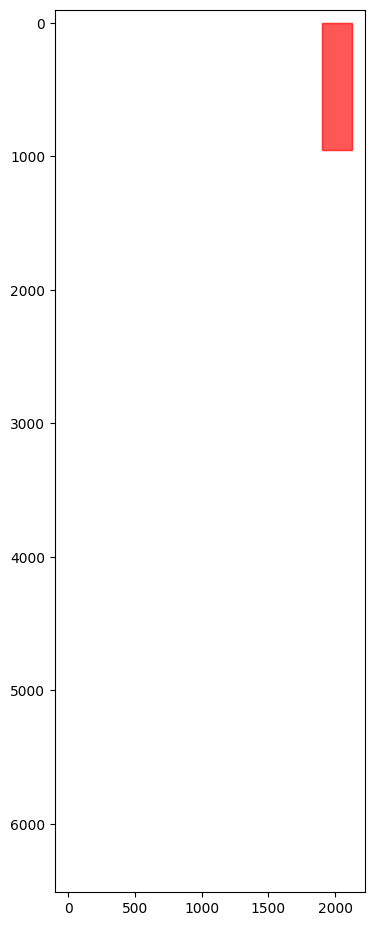

In [23]:
draw_rectangles(d[:300], True)